In [ ]:
# !pip install pyvi

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import string
from pyvi import ViTokenizer, ViPosTagger
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, callbacks, preprocessing, losses, optimizers, utils

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/My Drive/School/Năm 3/DataMining/FinalTerm

/content/drive/My Drive/School/Năm 3/DataMining/FinalTerm


In [5]:
%ls

data/               generate_text.ipynb  text-classification.ipynb
Final_Project.gdoc  model/               text_generator.ipynb


## Import data from source

In [3]:
vnexpress = pd.read_csv('./data/vnexpress/csv/vnexpress.csv').drop(columns=['Unnamed: 0'], axis=1)
vnexpress.shape

(2481, 6)

In [4]:
vnexpress.head()

,article_id,content,topic,sub-topic,title,description
0,0,"""Xin lỗi đi"". Nhiều thế hệ đã dùng câu này để ...",doi-song,to-am,Có nên bắt trẻ xin lỗi?,Một số cha mẹ cho rằng việc ép trẻ nói lời xin...
1,1,Một nghiên cứu của đại học Wisconsin-Madison (...,doi-song,to-am,Tác dụng bất ngờ của việc gọi cho mẹ,"Khi bạn có một ngày tồi tệ như sếp mắng, mất c..."
2,2,"Các yếu tố như độ tuổi của trẻ, mối quan hệ gi...",doi-song,to-am,"Thiệt thòi của trẻ 'nửa tuần ở với bố, nửa tuầ...","Khi cha mẹ mỗi người ở một nhà sau ly hôn, việ..."
3,3,Ở tuổi đôi mươi chị Trần Thị Liên kết hôn với ...,doi-song,to-am,Bi kịch ở tuổi 50 của người phụ nữ Hậu Giang,"Trong nhà tình nghĩa, vợ chồng chị Liên, 50 tu..."
4,4,"Chị Hoàng Thị Hòa, 34 tuổi, ở Hà Nam lấy chồng...",doi-song,to-am,Sốc văn hóa nhà chồng,"Về làm dâu, chị Hòa nhận ra đã bước chân vào m..."


In [5]:
vnexpress['tag'] = vnexpress['content'] + vnexpress['title'] + vnexpress['description']
vnexpress.drop(columns=['content', 'title', 'description'], inplace=True)

In [6]:
mask = vnexpress['tag'].isna()
vnexpress[mask]

,article_id,topic,sub-topic,tag
110,110,doi-song,bai-hoc-song,NaN
136,136,doi-song,bai-hoc-song,NaN
215,215,doi-song,nha,NaN
337,337,doi-song,tieu-dung,NaN
407,407,du-lich,diem-den,NaN
...,...,...,...,...
2338,2338,the-thao,photo,NaN
2353,2353,the-thao,photo,NaN
2361,2361,the-thao,photo,NaN
2381,2381,the-thao,photo,NaN


In [7]:
vnexpress.dropna(axis=0, inplace=True)
vnexpress.reset_index(inplace=True)
vnexpress.drop(columns=['index'], axis=1, inplace=True)
vnexpress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418 entries, 0 to 2417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  2418 non-null   int64 
 1   topic       2418 non-null   object
 2   sub-topic   2418 non-null   object
 3   tag         2418 non-null   object
dtypes: int64(1), object(3)
memory usage: 75.7+ KB


In [8]:
vnexpress['topic'].value_counts()

topic
giai-tri    614
the-thao    498
khoa-hoc    410
doi-song    361
giao-duc    355
du-lich     180
Name: count, dtype: int64

In [9]:
news = vnexpress.copy()
label_encoder = LabelEncoder()
news['topic'] = label_encoder.fit_transform(vnexpress['topic'])

news.head()

,article_id,topic,sub-topic,tag
0,0,0,to-am,"""Xin lỗi đi"". Nhiều thế hệ đã dùng câu này để ..."
1,1,0,to-am,Một nghiên cứu của đại học Wisconsin-Madison (...
2,2,0,to-am,"Các yếu tố như độ tuổi của trẻ, mối quan hệ gi..."
3,3,0,to-am,Ở tuổi đôi mươi chị Trần Thị Liên kết hôn với ...
4,4,0,to-am,"Chị Hoàng Thị Hòa, 34 tuổi, ở Hà Nam lấy chồng..."


In [10]:
X = news[['article_id', 'tag']]
y = news[['topic']]
news_train, news_test, label_train, label_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [11]:
print("The length of news_train: ", len(news_train))
print("The length of news_test: ", len(news_test))

The length of news_train:  1934
The length of news_test:  484


In [12]:
print(label_train.value_counts())
print(label_test.value_counts())

topic
2        483
5        393
4        336
0        301
3        272
1        149
Name: count, dtype: int64
topic
2        131
5        105
3         83
4         74
0         60
1         31
Name: count, dtype: int64


## Initialize the input sequences

In [13]:
def word_separation(sentences):
    return [sen.split() for sen in sentences]

In [30]:
def create_input(tokenizer, sequences:list, max_length:int):
    sequence_digit = tokenizer.texts_to_sequences(sequences)
    print(sequence_digit[0])
    print(type(sequence_digit))
    input_sequences = np.array(preprocessing.sequence.pad_sequences(sequence_digit, maxlen=max_length, padding='pre'))
    return input_sequences

In [15]:
def clean_document(doc):
    doc = ViTokenizer.tokenize(doc)
    doc = doc.lower() # lower
    tokens = doc.split() # split into words
    table = str.maketrans('', '', string.punctuation.replace("_", "")) # remove all punctuations
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word]
    return tokens

In [16]:
papers = news_train['tag'].tolist()
print(len(papers))
papers[0:1]

1934


['Khi bị động vật săn mồi tóm gọn, rắn dice trên đảo Golem Grad, hòn đảo giữa hồ ở Bắc Macedonia, tự làm bẩn chính nó bằng hỗn hợp phân và hợp chất mùi hăng. Sau đó, chúng bất động, miệng há to, lưỡi thè ra. Cuối cùng, để hoàn thiện màn giả chết, một số con thậm chí thổ huyết. Việc sử dụng máu để giả chết của loài rắn này có thể là mấu chốt để dựng lên màn biểu diễn thuyết phục, theo nghiên cứu công bố hôm 8/5 trên tạp chí Biology Letters. Nhiều loài trong vương quốc động vật giả chết khi bị động vật săn mồi quấy rầy, bao gồm côn trùng, cá và bò sát. Ngay cả động vật có vú cũng làm vậy. Hành vi giả chết có hiệu quả lớn đi kèm với rủi ro cao, theo Vukasin Bjelica, nghiên cứu sinh ở Đại học Belgrade, tác giả của bài báo. Một số động vật săn mồi tỏ ra bối rối hay kinh hãi khi thấy loài vật khác đột nhiên bất động, đặc biệt nếu chúng còn bốc mùi và chảy máu. Các động vật khác có thể ngừng theo dõi chăm chú và thả lỏng móng vuốt, giúp mồi săn có thời gian thoát thân. Nhưng điều đó đòi hỏi c

In [17]:
sequences = []
for seq in tqdm(papers):
  tokens = clean_document(seq)
  line = ' '.join(tokens)
  sequences.append(line)

  0%|          | 0/1934 [00:00<?, ?it/s]

100%|██████████| 1934/1934 [00:30<00:00, 62.81it/s]


In [18]:
print('Length of sequences:', len(sequences))
sequences[2]

Length of sequences: 1934


'nếu động_vật biển có vú muốn ngủ chúng không_thể nhắm_mắt và trôi lững_lờ trong đêm bởi chúng cần ngoi lên_mặt_nước giữa_chừng để lấy không_khí chúng cũng không_thể nổi trên mặt_nước và chìm vào giấc_ngủ do nguy_cơ gặp phải động_vật săn mồi và tình_trạng mất nhiệt theo live science một giải_pháp là ngừng hoạt_động một nửa não mỗi lần mang tên ngủ đơn bán_cầu đó là cách động_vật biển có vú như cá_heo nghỉ_ngơi giữa biển rộng ngủ đơn bán_cầu thật_sự hữu_ích đối_với những loài động_vật này bởi_vì cách đó cho phép chúng duy_trì mức_độ hoạt_động thấp trong khi vẫn ngủ một nửa não mỗi lần patrick_miller nhà sinh_vật_học ở đại_học st_andrews tại anh cho biết cá_heo là động_vật biển có vú được nghiên_cứu nhiều nhất có_thể ngủ kiểu này ảnh quét não cá heo nuôi nhốt cho thấy trong khi một bán_cầu trải qua giấc_ngủ sóng chậm sâu bán_cầu còn lại vẫn tỉnh_táo nhờ đó loài vật có_thể ngủ với một mắt mở kiểu ngủ như_vậy khá phổ_biến ở phân thứ bộ cá_voi nhóm động_vật có vú bao_gồm cá_heo cá_voi và cá

In [19]:
input_sequences = word_separation(sequences)
print(input_sequences[0:2])

[['khi', 'bị_động_vật', 'săn', 'mồi', 'tóm', 'gọn', 'rắn', 'dice', 'trên', 'đảo', 'golem_grad', 'hòn', 'đảo', 'giữa', 'hồ', 'ở', 'bắc_macedonia', 'tự', 'làm', 'bẩn', 'chính', 'nó', 'bằng', 'hỗn_hợp', 'phân', 'và', 'hợp_chất', 'mùi', 'hăng', 'sau', 'đó', 'chúng', 'bất_động', 'miệng', 'há', 'to', 'lưỡi', 'thè', 'ra', 'cuối_cùng', 'để', 'hoàn_thiện', 'màn', 'giả', 'chết', 'một_số', 'con', 'thậm_chí', 'thổ_huyết', 'việc', 'sử_dụng', 'máu', 'để', 'giả', 'chết', 'của', 'loài', 'rắn', 'này', 'có_thể', 'là', 'mấu_chốt', 'để', 'dựng', 'lên', 'màn', 'biểu_diễn_thuyết_phục', 'theo', 'nghiên_cứu', 'công_bố', 'hôm', '8', '5', 'trên', 'tạp_chí', 'biology_letters', 'nhiều', 'loài', 'trong', 'vương_quốc', 'động_vật', 'giả', 'chết', 'khi', 'bị_động_vật', 'săn', 'mồi', 'quấy_rầy', 'bao_gồm', 'côn_trùng', 'cá', 'và', 'bò_sát', 'ngay', 'cả', 'động_vật', 'có', 'vú', 'cũng', 'làm', 'vậy', 'hành_vi', 'giả', 'chết', 'có', 'hiệu_quả', 'lớn', 'đi', 'kèm', 'với', 'rủi_ro', 'cao', 'theo', 'vukasin_bjelica', 'nghi

In [ ]:
# filter several punctuations in 50803 sentences
tokenizer = preprocessing.text.Tokenizer(filters='!“"”#$%&()*+,-./:;<=>?@[\]^`{|}~ ', oov_token='<oov>')
# create vocabulary (corpus) for each word in 50803 sentences
tokenizer.fit_on_texts(input_sequences)

print(len(tokenizer.word_index))

In [21]:
# max_length = news['tag'].map(len).max()
max_length = max([len(i) for i in sequences])
max_length

19362

In [22]:
topic_size = len(news['topic'].unique()) + 1
topic_size

7

In [31]:
X_train = create_input(tokenizer, sequences, max_length)

print(len(X_train[0]))
print(X_train[0:2])

[13, 15607, 884, 1256, 6344, 1676, 1156, 9946, 27, 588, 21882, 1648, 588, 149, 619, 11, 15608, 257, 43, 1786, 178, 248, 81, 2962, 1471, 2, 2919, 1024, 15609, 24, 28, 186, 6345, 1615, 6727, 666, 2614, 21883, 37, 548, 16, 1296, 931, 1351, 861, 162, 51, 596, 15610, 66, 105, 1216, 16, 1351, 861, 3, 332, 1156, 26, 35, 5, 7167, 16, 1677, 69, 931, 21884, 31, 121, 939, 274, 249, 98, 27, 801, 21885, 20, 332, 4, 3728, 629, 1351, 861, 13, 15607, 884, 1256, 9947, 650, 1890, 559, 2, 5521, 266, 109, 629, 10, 2425, 32, 43, 966, 1210, 1351, 861, 10, 486, 90, 50, 1011, 6, 1934, 71, 31, 21886, 3258, 11, 133, 11203, 527, 3, 235, 874, 162, 629, 884, 1256, 2285, 37, 3830, 86, 15611, 13, 94, 332, 1387, 78, 6728, 6345, 287, 123, 186, 45, 3077, 1024, 2, 7682, 7, 629, 78, 35, 1302, 914, 9021, 2, 7683, 1757, 8266, 61, 1256, 884, 10, 103, 9022, 40, 114, 28, 1626, 51, 1387, 190, 1531, 52, 264, 5774, 4, 13, 10, 1521, 148, 138, 754, 248, 1016, 51, 1256, 10, 1164, 188, 76, 932, 674, 103, 1351, 861, 121, 3, 9948, 515

In [27]:
## Sửa định dạng y
y_train = np.array([label_train['topic']])
y_train = y_train.reshape(-1, 1)
y_train = utils.to_categorical(y_train, num_classes=topic_size)

print(y[0:5])

   topic
0      0
1      0
2      0
3      0
4      0


## Design the LSTM model

In [28]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

36714

In [29]:
drop_out = 0.2
output_unit = topic_size
embedding_size = 128

In [30]:
model = models.Sequential([
  layers.Embedding(vocab_size, embedding_size),
  layers.BatchNormalization(),
  layers.LSTM(64, return_sequences=True),
  layers.LSTM(64),
  layers.Dropout(drop_out),
  layers.Dense(9, activation='relu'),
  layers.Dense(9, activation='relu'),
  layers.Dense(9, activation='relu'),
  layers.Dense(9, activation='relu'),
  layers.Dense(units=output_unit, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         4699392   
                                                                 
 batch_normalization (Batch  (None, None, 128)         512       
 Normalization)                                                  
                                                                 
 lstm (LSTM)                 (None, None, 64)          49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 9)                 585       
                                                        

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model.fit(X_train, y_train, epochs=25, batch_size=64)

Epoch 1/25
31/31 [==============================] - 35s 1s/step - loss: 1.5123 - accuracy: 0.4498
Epoch 2/25
31/31 [==============================] - 36s 1s/step - loss: 1.3010 - accuracy: 0.4617
Epoch 3/25
31/31 [==============================] - 35s 1s/step - loss: 1.0923 - accuracy: 0.4876
Epoch 4/25
31/31 [==============================] - 35s 1s/step - loss: 0.9594 - accuracy: 0.4835
Epoch 5/25
31/31 [==============================] - 35s 1s/step - loss: 0.8481 - accuracy: 0.5093
Epoch 6/25
31/31 [==============================] - 35s 1s/step - loss: 0.7342 - accuracy: 0.6101
Epoch 7/25
31/31 [==============================] - 36s 1s/step - loss: 0.5942 - accuracy: 0.7689
Epoch 8/25
31/31 [==============================] - 36s 1s/step - loss: 0.4808 - accuracy: 0.7689
Epoch 9/25
31/31 [==============================] - 35s 1s/step - loss: 0.4037 - accuracy: 0.7725
Epoch 10/25
31/31 [==============================] - 36s 1s/step - loss: 0.3743 - accuracy: 0.7937
Epoch 11/25
31/31 [

KeyboardInterrupt: 

## Dump model into files

In [ ]:
# %cd /content/drive/My Drive/School/Năm 3/DataMining/FinalTerm/model

In [ ]:
import pickle
model.save('text_classify_model.h5')

with open('text_classify_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

## Predict samples and Evaluate on test dataset

In [ ]:
import pickle
model = models.load_model('./model/text_classify_model.h5')

with open('./model/text_classify_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [34]:
def normalize_text(text, tokenizer, max_length):
    tokeninzed_sequences = clean_document(text)
    sequences_digit = tokenizer.texts_to_sequences([tokeninzed_sequences])
    sequences_digit_padding = np.array(preprocessing.sequence.pad_sequences(sequences_digit, maxlen=max_length, padding='pre'))
    return sequences_digit_padding

* Predict a sample

In [77]:
sample_text = '''
Phan Đăng Hoàng, 23 tuổi, là nhà thiết kế Việt duy nhất Forbes vinh danh "Nghệ sĩ dưới 30 tuổi có tầm ảnh hưởng ở châu Á".

Trong phần giới thiệu gương mặt thuộc hạng mục The Arts, công bố ngày 16/5, Forbes viết: "Phan Đăng Hoàng là nhà thiết kế thời trang người Việt, tốt nghiệp La Nuova accademia di belle arti tại Milan. Trở về Việt Nam, anh ra mắt thương hiệu riêng, từng giới thiệu bộ sưu tập tại Tuần lễ thời trang Milan".

Phan Đăng Hoàng nói hạnh phúc trước sự ghi nhận. Anh được thông báo vào đề cử hạng mục hồi tháng 3, sau đó tiến hành làm hồ sơ gửi đi để ban tổ chức xét duyệt. "Hai tháng qua, tôi hồi hộp chờ đợi và vỡ òa vì thực sự đây là giấc mơ. Đây là động lực lớn với tôi trong chặng đường làm nghề sắp tới".
'''

In [80]:
temp = normalize_text(text=sample_text, tokenizer=tokenizer, max_length=max_length)
print(temp)

prediction = model.predict(temp)
print(prediction)

[[   0    0    0 ...  546 1188   87]]
1/1 [==============================] - 1s 1s/step
[[3.8530384e-03 9.8752402e-09 9.9614692e-01 4.9970781e-13 8.1713380e-13
  9.0039708e-16 6.7121269e-14]]


In [81]:
result = label_encoder.inverse_transform([np.argmax(prediction[0])])
result

array(['giai-tri'], dtype=object)

* Evaluate performance

In [ ]:
papers = news_test['tag'].tolist()
print(len(papers))

In [39]:
sequences_test = []
for seq in tqdm(papers):
  tokens = clean_document(seq)
  line = ' '.join(tokens)
  sequences_test.append(line)

100%|██████████| 484/484 [00:05<00:00, 84.41it/s]


In [82]:
X_test = create_input(tokenizer, sequences_test, max_length)

print(len(X_test[0]))
print(X_test[0:2])

19362
[[    0     0     0 ... 17806     3    22]
 [    0     0     0 ...  3839   881    99]]


In [83]:
prediction = model.predict(X_test)
print(prediction)

16/16 [==============================] - 6s 378ms/step
[[9.8521960e-01 1.4395811e-02 3.8428715e-04 ... 1.1981915e-10
  4.6032075e-17 1.5749091e-10]
 [7.7254422e-02 8.7108714e-07 9.2274475e-01 ... 2.5355044e-12
  4.8677755e-16 1.0200513e-12]
 [8.9728971e-26 1.9460379e-21 2.6630151e-21 ... 1.8669970e-03
  9.9813288e-01 2.7949772e-24]
 ...
 [2.4271754e-03 8.2468218e-01 1.0646195e-08 ... 4.5956978e-05
  4.5604194e-13 1.0247684e-08]
 [7.7240795e-02 9.2231369e-01 1.8696507e-07 ... 3.2922141e-08
  8.0584459e-16 5.2300453e-09]
 [3.7195696e-03 9.2340002e-09 9.9628037e-01 ... 7.9860424e-13
  8.2436846e-16 5.9299225e-14]]


In [84]:
predictions = [np.argmax(pred) for pred in prediction]
print(mean_squared_error(label_test, predictions))
print(r2_score(label_test, predictions))

0.7045454545454546
0.7320518544374184


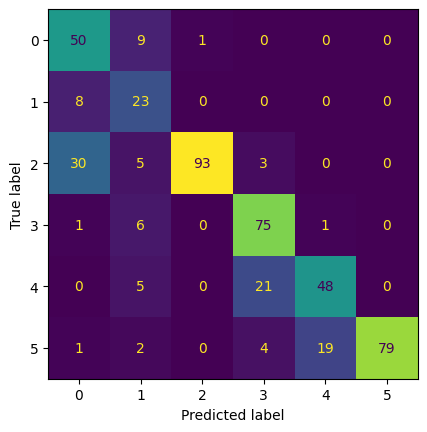

In [85]:
cm = confusion_matrix(label_test, predictions)
cfm = ConfusionMatrixDisplay(confusion_matrix=cm)
cfm.plot(colorbar=False)

In [86]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.56      0.83      0.67        60
           1       0.46      0.74      0.57        31
           2       0.99      0.71      0.83       131
           3       0.73      0.90      0.81        83
           4       0.71      0.65      0.68        74
           5       1.00      0.75      0.86       105

    accuracy                           0.76       484
   macro avg       0.74      0.76      0.73       484
weighted avg       0.82      0.76      0.77       484

